<a href="https://colab.research.google.com/github/DARSANDEV/PythonTrading/blob/LSTM-2.0/LSTM2.0%20test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

# New Section

In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=f1736d6a02d66af1586279ef95154bdee4488861284965c8410fe3559a845aa8
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [ ]:
import json
import pandas as pd
from datetime import datetime
import pytz
import websocket
from IPython.display import clear_output, display

ist = pytz.timezone('Asia/Kolkata')
error_logs = []

class DataCollector:
    def __init__(self, symbol="NSE:NIFTY", time_frame="5", period=100):
        self.socketUrl = "wss://data.tradingview.com/socket.io/websocket"
        self.symbol = symbol
        self.time_frame = time_frame
        self.period = period
        self.df = pd.DataFrame(columns=['TimeStamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
        self.ws = None

    def on_message(self, ws, message):
        """Handles incoming WebSocket messages."""
        try:
            start = message.find('"s":[')
            ends = message.find(',"ns":{')
            fdata = json.loads(message[start+4:ends])

            if isinstance(fdata, list):
                for item in fdata:
                    if 'v' in item:
                        timestamp_utc = datetime.utcfromtimestamp(item['v'][0])
                        timestamp_ist = timestamp_utc.replace(tzinfo=pytz.utc).astimezone(ist)
                        item['v'][0] = timestamp_ist.strftime('%Y-%m-%d %H:%M:%S')
                        self.df.loc[len(self.df)] = item['v']
                    else:
                        error_logs.append(f"Warning: Item does not have 'v' key: {item}")
            else:
                error_logs.append(f"Error: fdata is not a list. Type: {type(fdata)}, Value: {fdata}")

        except Exception as e:
            error_logs.append(f"Error extracting candle data: {e}")

        clear_output(wait=True)
        for error in error_logs:
            print(error)
        display(self.df)

    def on_error(self, ws, error):
        """Handles WebSocket errors."""
        print(f"WebSocket Error: {error}")

    def on_close(self, ws, close_status_code, close_msg):
        """Handles WebSocket closure."""
        print("WebSocket Closed")

    def on_open(self, ws):
        """Sends initialization messages when WebSocket is opened."""
        print("WebSocket Connection Established!")

        def create_message(func, arg):
            ms = json.dumps({"m": func, "p": arg})
            msg = f"~m~{len(ms)}~m~{ms}"
            ws.send(msg)

        session_id = "0.13918.2153_mum1-charts-26-webchart-16"
        create_message("chart_create_session", [session_id, ""])
        chart_id = '=' + json.dumps({"adjustment": "splits", "session": "regular", "symbol": self.symbol})
        create_message("resolve_symbol", [session_id, "sds_sym_1", chart_id])
        create_message("create_series", [session_id, "sds_1", "s1", "sds_sym_1", self.time_frame, self.period, ""])

    def start(self):
        """Starts WebSocket connection."""
        self.ws = websocket.WebSocketApp(self.socketUrl,
                                         on_message=self.on_message,
                                         on_error=self.on_error,
                                         on_close=self.on_close)
        self.ws.on_open = self.on_open
        self.ws.run_forever()

# Function to fetch live data
def get_live_data(symbol="NSE:NIFTY", time_frame="5", period=100):
    collector = DataCollector(symbol,time_frame,period)
    collector.start()
    return collector.df


In [ ]:

import pandas_ta as ta

def add_indicators(data):
    """Adds technical indicators to the data."""
    data['5MIN_RSI'] = ta.rsi(data.Close, length=14).round(2)
    data['5MIN_EMA21'] = ta.ema(data.Close, length=21).round(2)
    data['5MIN_EMA9'] = ta.ema(data.Close, length=9).round(2)
    data['5MIN_EMA50'] = ta.ema(data.Close, length=50).round(2)

    data["ATR"] = data.ta.atr(length=14).round(2)
    data["ADX"] = data.ta.adx(length=14)["ADX_14"].round(2)
    dmi = data.ta.adx(length=14)
    data["+DI"] = dmi["DMP_14"].round(2)
    data["-DI"] = dmi["DMN_14"].round(2)

    data["Pivot"] = (data["High"] + data["Low"] + data["Close"]) / 3
    data["R1"] = (2 * data["Pivot"]) - data["Low"]
    data["R2"] = data["Pivot"] + (data["High"] - data["Low"])
    data["S1"] = (2 * data["Pivot"]) - data["High"]
    data["S2"] = data["Pivot"] - (data["High"] - data["Low"])

    data[["Pivot", "S1", "S2", "R1", "R2"]] = data[["Pivot", "S1", "S2", "R1", "R2"]].round(2)
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    return data


In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import LSTM, Dense, Input, Activation
from sklearn.preprocessing import MinMaxScaler

def train_lstm_model(data):
    """Trains LSTM model and returns trained model."""
    data_set = data.iloc[:, 0:11]
    sc = MinMaxScaler(feature_range=(0, 1))
    data_set_scaled = sc.fit_transform(data_set)

    X, y = [], []
    backcandles = 30
    for i in range(backcandles, data_set_scaled.shape[0]):
        X.append(data_set_scaled[i - backcandles:i])
        y.append(data_set_scaled[i, -1])

    X, y = np.array(X), np.array(y).reshape(-1, 1)

    # Split data
    splitlimit = int(len(X) * 0.8)
    X_train, X_test = X[:splitlimit], X[splitlimit:]
    y_train, y_test = y[:splitlimit], y[splitlimit:]

    # Model definition
    lstm_input = Input(shape=(backcandles, 11), name='lstm_input')
    inputs = LSTM(150, name='first_layer')(lstm_input)
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('linear', name='output')(inputs)
    model = Model(inputs=lstm_input, outputs=output)

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, batch_size=15, epochs=30, validation_split=0.1)

    return model, X_test, y_test


In [ ]:
df = get_live_data(period=1000)

Error extracting candle data: Extra data: line 1 column 4 (char 3)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 4 (char 3)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 4 (char 3)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (cha

,TimeStamp,Open,High,Low,Close,Volume
0,2025-02-21 13:25:00,22774.20,22778.65,22749.75,22753.55,2997905.0
1,2025-02-21 13:30:00,22751.80,22768.80,22751.55,22765.80,1929228.0
2,2025-02-21 13:35:00,22764.40,22767.05,22723.80,22726.95,3527640.0
3,2025-02-21 13:40:00,22726.70,22739.50,22721.80,22735.60,2719928.0
4,2025-02-21 13:45:00,22735.25,22736.40,22720.30,22730.95,2683692.0
...,...,...,...,...,...,...
995,2025-03-13 15:05:00,22392.85,22401.55,22380.60,22398.00,5860900.0
996,2025-03-13 15:10:00,22398.80,22402.85,22387.70,22399.60,6495261.0
997,2025-03-13 15:15:00,22399.50,22412.75,22394.05,22408.55,10009666.0
998,2025-03-13 15:20:00,22407.85,22410.45,22396.95,22402.90,8455230.0


WebSocket Closed


In [ ]:
import pandas as pd

def add_target_class(data):
    """Adds Target and TargetClass to the dataset."""
    data["Adj Close"] = data["Close"].shift(1)
    data['Target'] = data['Adj Close'] - data['Open']
    data['Target'] = data['Target'].shift(-1)

    # Add TargetClass (Binary classification: 1 if price increases, 0 otherwise)
    data['TargetClass'] = (data['Target'] > 0).astype(int)

    return data

def drop_data(data):
    """Cleans and preprocesses data by removing NaN values and unnecessary columns."""
    data = data.dropna().reset_index(drop=True)  # Ensures fresh indexing
    data = data.drop(['Close', 'TimeStamp'], axis=1, errors='ignore')  # Prevent KeyError if column is missing
    return data

def preprocess_data(data):
    """Runs the full preprocessing pipeline."""
    data = add_target_class(data)
    data = drop_data(data)
    return data


In [ ]:
data = get_live_data(period=1000)

Error extracting candle data: Extra data: line 1 column 4 (char 3)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 4 (char 3)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 4 (char 3)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (char 1)
Error extracting candle data: Extra data: line 1 column 2 (cha

,TimeStamp,Open,High,Low,Close,Volume
0,2025-02-21 13:25:00,22774.20,22778.65,22749.75,22753.55,2997905.0
1,2025-02-21 13:30:00,22751.80,22768.80,22751.55,22765.80,1929228.0
2,2025-02-21 13:35:00,22764.40,22767.05,22723.80,22726.95,3527640.0
3,2025-02-21 13:40:00,22726.70,22739.50,22721.80,22735.60,2719928.0
4,2025-02-21 13:45:00,22735.25,22736.40,22720.30,22730.95,2683692.0
...,...,...,...,...,...,...
995,2025-03-13 15:05:00,22392.85,22401.55,22380.60,22398.00,5860900.0
996,2025-03-13 15:10:00,22398.80,22402.85,22387.70,22399.60,6495261.0
997,2025-03-13 15:15:00,22399.50,22412.75,22394.05,22408.55,10009666.0
998,2025-03-13 15:20:00,22407.85,22410.45,22396.95,22402.90,8455230.0


WebSocket Closed


In [ ]:
#df = get_live_data(period=100)
df=data.copy()
# Step 2: Add indicators
df = add_indicators(df)

df = preprocess_data(df)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0675 - val_loss: 0.0123
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0080 - val_loss: 0.0074
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0035 - val_loss: 0.0054
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 9/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 10/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 11/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 12/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.4

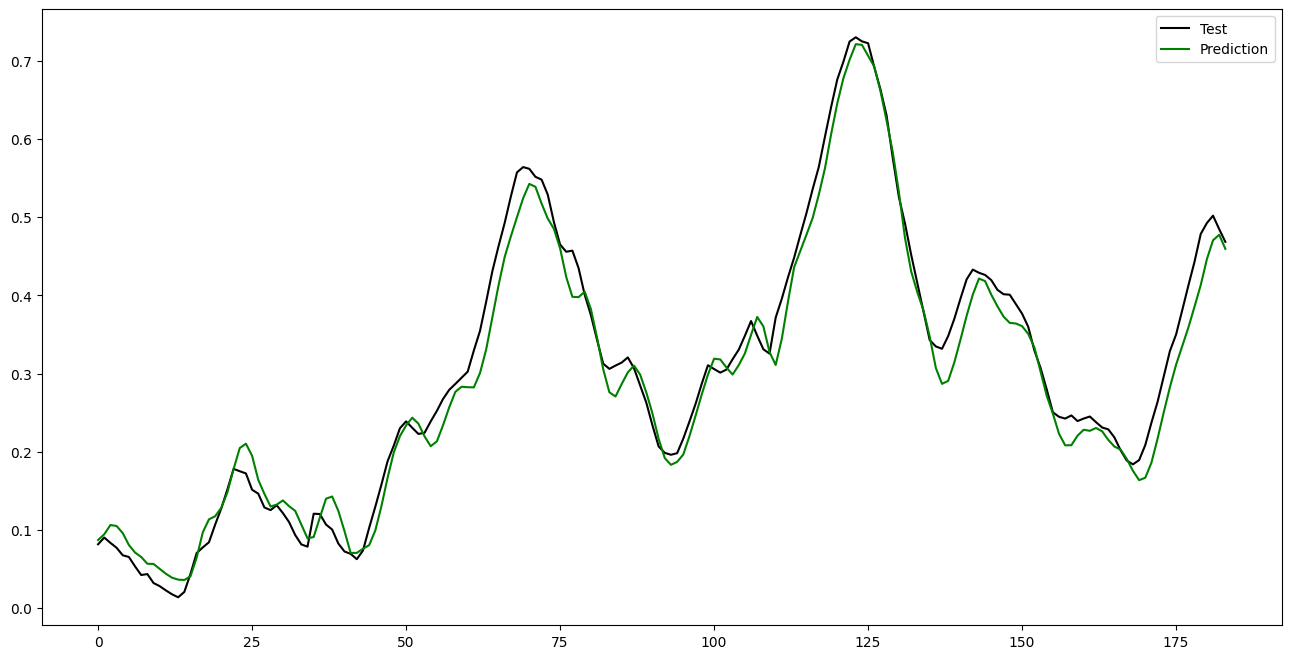

In [ ]:
# from data_collector import get_live_data
# from indicators import add_indicators
# from lstm_model import train_lstm_model
import matplotlib.pyplot as plt



# Step 3: Train LSTM model
model, X_test, y_test = train_lstm_model(df)

# Step 4: Make predictions
y_pred = model.predict(X_test)

# Step 5: Plot results
plt.figure(figsize=(16, 8))
plt.plot(y_test, color='black', label='Test')
plt.plot(y_pred, color='green', label='Prediction')
plt.legend()
plt.show()


In [ ]:
print (df)

     index      Open      High       Low      Volume  5MIN_RSI  5MIN_EMA21  \
0       50  22579.45  22583.80  22576.70   1962223.0     41.79    22590.30   
1       51  22579.55  22580.60  22563.75   1605829.0     40.30    22588.84   
2       52  22574.30  22577.40  22568.65   1619259.0     41.39    22587.76   
3       53  22576.85  22580.80  22572.85   1978019.0     42.70    22587.05   
4       54  22579.65  22611.85  22579.10   2628326.0     53.69    22589.14   
..     ...       ...       ...       ...         ...       ...         ...   
944    994  22386.40  22395.30  22377.35   6271728.0     35.55    22414.08   
945    995  22392.85  22401.55  22380.60   5860900.0     38.72    22412.62   
946    996  22398.80  22402.85  22387.70   6495261.0     39.80    22411.44   
947    997  22399.50  22412.75  22394.05  10009666.0     45.60    22411.17   
948    998  22407.85  22410.45  22396.95   8455230.0     42.79    22410.42   

     5MIN_EMA9  5MIN_EMA50    ATR  ...    +DI    -DI     Pivot 